# Multi-class Bayesian Logistic Regression with PyMC3 ~ Softmax Regression
* From the "Bayesian Analysis with Python" book repository
* written by Osvaldo Martin 
- credit: https://github.com/aloctavodia/BAP/blob/master/code_3_11/Chp4/04_Generalizing_linear_models.ipynb

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt

In [3]:
# import arviz as az
# az.style.use('arviz-darkgrid')

## Explore the Iris Flower dataset

In [4]:
iris = pd.read_csv('./data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

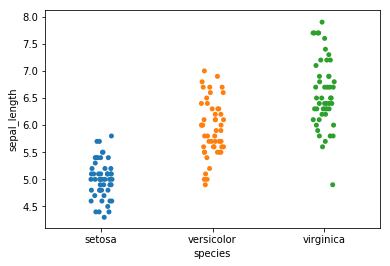

In [6]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True);

/home/sara/anaconda3/envs/bayes/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


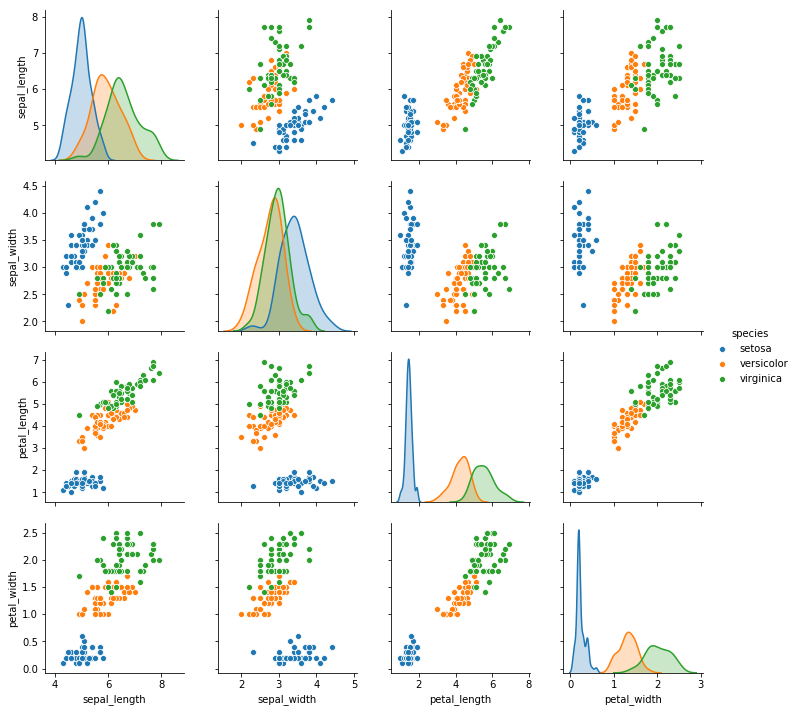

In [7]:
sns.pairplot(iris, hue='species', diag_kind='kde');

## Preparing the data for Bayesian Softmax Regression

In [8]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes       # {0,1,2} number of labels=3 "species of flowers"
x_n = iris.columns[:-1]
x_s = iris[x_n].values                            # shape: (150, 4)  number of datapoints=150, number of features=4
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)  # standardizing the features values
print(x_s.shape)

(150, 4)


## Softmax Bayesian Regression

In [9]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)             # bias term
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))         # feature weight
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))  # linear combination of the features
    θ = tt.nnet.softmax(μ)                              # softmax prediction (150, 3)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_s = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

/home/sara/anaconda3/envs/bayes/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/sara/anaconda3/envs/bayes/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sara/anaconda3/envs/bayes/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: 

In [10]:
idata_s[0]['μ'].shape
idata_s[0].keys()

dict_keys(['α', 'β', 'μ'])

In [11]:
len(idata_s)

2000

In [12]:
idata_s.nchains

4

In [13]:
idata_s.varnames

['α', 'β', 'μ']

In [14]:
idata_s.chains

[0, 1, 2, 3]

In [15]:
idata_s.points, idata_s.points()

(<bound method MultiTrace.points of <MultiTrace: 4 chains, 2000 iterations, 3 variables>>,
 <itertools.chain at 0x7f76ad5409d0>)

In [23]:
i = 0
num_iter = idata_s.nchains * len(idata_s)
updated_vals = idata_s.get_values('μ')[0]
for pmc_iter in range(1, num_iter):
    curr_μ = idata_s.get_values('μ')[pmc_iter]
    updated_vals = np.vstack([curr_μ, updated_vals])
    # print(pmc_iter.shape)   # (150,3) for each iteration we have (150,3) μ : logit values of 150 datapoints: (150, 3) (to be passed to softmax predcition next) 
    i+=1
print(updated_vals.shape)

(1200000, 3)


In [48]:
# DONT REMOVE
# i = 0
# for pmc_iter in idata_s.points(): # 8000 iterations (i.e. number of points = 4 chains x 2000 iterations)
#     logits_vals = np.vstack(
    # print(pmc_iter.keys())        # dict_keys(['α', 'β', 'μ'])
    # print(pmc_iter['μ'].shape)    # (150,3) for each iteration we have (150,3) μ : logit values of 150 datapoints: (150, 3) (to be passed to softmax predcition next)
    # print(pmc_iter['β'].shape)    # (4,3)   for each iteration we have   (4,3) β
    # print(pmc_iter['α'].shape)    # (3,)    for each iteration we have    (3,) α

#     i+=1
# print(i)

8000


## Accuracy for training data

In [32]:
# DONT REMOVE
print(idata_s.get_values('μ').shape)   # shape (8000, 150, 3) ---> (num_iters, num_data_points, num_classes)
print(idata_s.get_values('α').shape)   # shape (8000, 3)      ---> (num_iters, num_classes)
print(idata_s.get_values('β').shape)   # shape (8000, 4, 3)   ---> (num_iters, num_feats, num_classes)

(8000, 150, 3)
(8000, 3)
(8000, 4, 3)


In [39]:
# data_pred = idata_s.posterior['μ'].mean(("chain", "draw"))   # obsolete

# get logits by averaging over the num_iters (here 8000)
# shape of μ is (num_iters, num_data_points, num_classes)
data_pred = idata_s.get_values('μ').mean(axis=0)   # logits for training data: shape (150, 3)

# softmax prediction for the 150 datapoint in the training dataset
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]   # len(y_pred) = num_data_points

# accuracy of the training data = 98%
print(f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}')  

0.98


## Predicting test data

### mean or mode?

In [80]:
from scipy import stats

a = np.array([[1, 3, 4, 2, 2, 7],
              [5, 2, 2, 1, 4, 1],
              [3, 3, 2, 2, 1, 1]])

print(a.shape)
m = stats.mode(a, axis=0)
m[0].shape, (m[0].squeeze()).shape, m[0].squeeze()

(3, 6)


((1, 6), (6,), array([1, 3, 2, 2, 1, 1]))

In [89]:
a.shape, np.median(a, axis=0).shape

((3, 6), (6,))

In [90]:
def get_softmax_prediction(x_test, y_test, α, β, estimate_type='mean'):   
    '''
    x_test: held-out test data.     shape = (num_data_points, num_feats)
    y_test: held-out true labels.   shape = (num_data_points,)
    α: bias term.                   shape = (num_iters, num_classes)
    β: features weights.            shape = (num_iters, num_feats, num_classes)
    estimate_type: available options = ['mean', 'median', 'mode'], default value is: 'mean'
    '''
    if estimate_type == "mean":
        y_pred = α.mean(axis=0) + np.dot(x_test, β.mean(axis=0))    # first term shape: ?? , second term shape: (num_points, num_classes)
    
    elif estimate_type == "median":
        y_pred = np.median(α, axis=0) + np.dot(x_test, np.median(β, axis=0))
        
    elif estimate_type == "mode":
        α_mode = stats.mode(α, axis=0)[0].squeeze()
        β_mode = stats.mode(β, axis=0)[0].squeeze()
        y_pred = α_mode + np.dot(x_test, β_mode)
    proba = np.exp(y_pred).T/np.sum(np.exp(y_pred), axis=1)
    p_class = np.argmax(proba, axis=0)
    
    accuracy = np.sum(y_test == np.argmax(y_pred, axis=1)) / len(y_test)
    return proba, p_class, accuracy * 100

In [91]:
α = idata_s.get_values('α')
β = idata_s.get_values('β')

# hint: 'mode' estimate type takes more time than 'mean' and 'median'
y_proba, y_pred, accuracy = get_softmax_prediction(x_s, y_s, α, β, estimate_type='median')
accuracy

98.0